<a href="https://colab.research.google.com/github/xiaossr/68300-final-project/blob/main/clip_token_ablation_cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xt66pg14
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xt66pg14
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import clip

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from transformers import CLIPVisionModelWithProjection, CLIPProcessor, CLIPModel, CLIPVisionModel

# cifar-10

## effect of local-only and global-ablated ablations on task performances

In [3]:
import torch
import torchvision
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load CLIP model & processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(
    model_name,
    output_attentions=True,
    attn_implementation="eager"
).to(device).eval()
processor = CLIPProcessor.from_pretrained(model_name)

# 2) Prepare CIFAR-10 dataloader (images only for attention stats)
# test: cifar-100
# cifar = torchvision.datasets.CIFAR10(root=".", train=False, download=True)
cifar = torchvision.datasets.CIFAR100(root=".", train=False, download=True)
def collate_fn(batch):
    imgs, _ = zip(*batch)
    pix = processor(images=list(imgs), return_tensors="pt")["pixel_values"].to(device)
    return pix

dl = DataLoader(cifar, batch_size=32, shuffle=False,
                collate_fn=collate_fn, num_workers=0)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 169M/169M [00:03<00:00, 43.1MB/s]


In [4]:
# 3) Build patch distance matrix (Euclidean)
seq_len = model.config.vision_config.image_size // model.config.vision_config.patch_size
P = seq_len * seq_len
coords = [(i // seq_len, i % seq_len) for i in range(P)]
dist_mat = torch.zeros((P, P), device=device)
for i, (x1, y1) in enumerate(coords):
    for j, (x2, y2) in enumerate(coords):
        dist_mat[i, j] = np.hypot(x1-x2, y1-y2)

num_layers = model.config.vision_config.num_hidden_layers
num_heads = model.config.vision_config.num_attention_heads

print(num_heads)

12


In [5]:
# 4) Accumulators for weighted distance and total weight per (layer, head)
num_accum = torch.zeros((num_layers, num_heads), device=device)
den_accum = torch.zeros((num_layers, num_heads), device=device)

max_batches = 200  # limit for speed; adjust as needed
for batch_idx, maybe_batch in enumerate(dl):
    # if it’s a tuple/list, assume pix is the first element
    pix = maybe_batch[0] if isinstance(maybe_batch, (tuple, list)) else maybe_batch
    if batch_idx >= max_batches:
        break
    with torch.no_grad():
        out = model.vision_model(pixel_values=pix, output_attentions=True)
    attn = out.attentions  # tuple length num_layers, each [B, heads, seq_len+1, seq_len+1]
    for l_idx, A in enumerate(attn):
        # drop CLS token: select tokens 1..P
        A_pp = A[:, :, 1:, 1:]  # [B, heads, P, P]
        # average over batch
        A_mean = A_pp.mean(dim=0)  # [heads, P, P]
        # accumulate weighted dist and total weight
        # reshape dist_mat to [1, P, P] for broadcasting
        weighted = A_mean * dist_mat.unsqueeze(0)
        num_accum[l_idx] += weighted.sum(dim=(1,2))
        den_accum[l_idx] += A_mean.sum(dim=(1,2))

In [6]:
# 5) Compute mean distances and rank heads
mean_dist = num_accum / den_accum  # [layers, heads]
head_stats = []
for l in range(num_layers):
    for h in range(num_heads):
        head_stats.append((l, h, mean_dist[l, h].item()))
head_stats.sort(key=lambda x: x[2])


In [7]:
# 6) Select top 2 most local & global heads per layer
num_select = 1
local_dict = {}
global_dict = {}
for l in range(num_layers):
    distances = mean_dist[l]               # [heads]
    sorted_heads = torch.argsort(distances)
    local_heads = sorted_heads[:num_select].tolist()
    global_heads = sorted_heads[-num_select:].tolist()
    local_dict[l] = local_heads
    global_dict[l] = global_heads
    print(f"Layer {l}: Local heads -> {local_heads}; Global heads -> {global_heads}")

Layer 0: Local heads -> [8]; Global heads -> [3]
Layer 1: Local heads -> [11]; Global heads -> [9]
Layer 2: Local heads -> [3]; Global heads -> [8]
Layer 3: Local heads -> [5]; Global heads -> [10]
Layer 4: Local heads -> [4]; Global heads -> [2]
Layer 5: Local heads -> [5]; Global heads -> [1]
Layer 6: Local heads -> [10]; Global heads -> [0]
Layer 7: Local heads -> [10]; Global heads -> [11]
Layer 8: Local heads -> [1]; Global heads -> [11]
Layer 9: Local heads -> [10]; Global heads -> [0]
Layer 10: Local heads -> [1]; Global heads -> [4]
Layer 11: Local heads -> [1]; Global heads -> [8]


In [10]:
# 7) Prepare text features for zero-shot eval on CIFAR-10
# cifar_full = torchvision.datasets.CIFAR10(root=".", train=False, download=False)
cifar_full = torchvision.datasets.CIFAR100(root=".", train=False, download=False)
labels = cifar_full.classes
prompts = [f"a photo of a {lbl}" for lbl in labels]
text_inputs = processor(text=prompts, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    text_feats = model.get_text_features(**text_inputs)
    text_feats /= text_feats.norm(dim=-1, keepdim=True)

# 8) Dataloader with labels for evaluation
def collate_fn_eval(batch):
    imgs, lbs = zip(*batch)
    pix = processor(images=list(imgs), return_tensors="pt")["pixel_values"].to(device)
    return pix, torch.tensor(lbs, device=device)

dl_eval = DataLoader(cifar_full, batch_size=64, collate_fn=collate_fn_eval, num_workers=0)

# 9) Save original v_proj weights
orig_v = [layer.self_attn.v_proj.weight.data.clone()
          for layer in model.vision_model.encoder.layers]


# Ablation helper
def ablate(head_dict, keep: bool):
    for idx, layer in enumerate(model.vision_model.encoder.layers):
        w = layer.self_attn.v_proj.weight.data
        head_dim = w.shape[0] // num_heads
        if keep:
            to_ablate = [h for h in range(num_heads) if h not in head_dict.get(idx, [])]
        else:
            to_ablate = head_dict.get(idx, [])
        for h in to_ablate:
            start, end = h*head_dim, (h+1)*head_dim
            w[start:end, :] = 0.0

# Zero-shot eval function
@torch.no_grad()
def eval_zero_shot():
    correct = total = 0
    for pix, lbs in dl_eval:
        img_feats = model.get_image_features(pixel_values=pix)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        logits = img_feats @ text_feats.T
        preds = logits.argmax(dim=-1)
        correct += (preds == lbs).sum().item()
        total += lbs.size(0)
    return correct / total

In [11]:
def restore_weights():
    for layer, w0 in zip(model.vision_model.encoder.layers, orig_v):
        layer.self_attn.v_proj.weight.data.copy_(w0)

sorted_heads_per_layer = [
    torch.argsort(mean_dist[l]).tolist()
    for l in range(num_layers)
]
global_heads_per_layer = [
    list(reversed(sorted_heads_per_layer[l]))
    for l in range(num_layers)
]

baseline_acc = eval_zero_shot()
ks = list(range(1, num_heads + 1))
acc_local  = []
acc_global = []

for k in ks:
    # — Ablate k most local heads in *every* layer —
    restore_weights()
    head_dict = {l: sorted_heads_per_layer[l][:k] for l in range(num_layers)}
    ablate(head_dict, keep=False)
    acc_local.append(eval_zero_shot())

    # — Ablate k most global heads in *every* layer —
    restore_weights()
    head_dict = {l: global_heads_per_layer[l][:k] for l in range(num_layers)}
    ablate(head_dict, keep=False)
    acc_global.append(eval_zero_shot())

In [12]:
dist_local, dist_global = [], []

for k in ks:
    # — Local ablation —
    hd_local = {l: sorted_heads_per_layer[l][:k] for l in range(num_layers)}
    # compute avg distance of all removed heads
    removed_dists = []
    for l, heads in hd_local.items():
        removed_dists += mean_dist[l, heads].tolist()
    dist_local.append(sum(removed_dists)/len(removed_dists))

    # — Global ablation —
    hd_global = {l: global_heads_per_layer[l][:k] for l in range(num_layers)}
    removed_dists = []
    for l, heads in hd_global.items():
        removed_dists += mean_dist[l, heads].tolist()
    dist_global.append(sum(removed_dists)/len(removed_dists))

In [13]:
# values
print("removed heads\tlocal ablation\tlocal distance\tglobal ablation\tglobal distance\t")
print(f"0\t\t{baseline_acc}\t\tn/a\t\t{baseline_acc}\t\tn/a")

# ANSI color codes
GREEN = "\033[92m"
RESET = "\033[0m"

for i in range(len(ks)):
    k    = ks[i]
    la   = acc_local[i]
    ga   = acc_global[i]
    ld   = dist_local[i]
    gd   = dist_global[i]

    # Highlight the larger accuracy in green
    la_str = f"{GREEN}{la:.4f}{RESET}" if la > ga else f"{la:.4f}"
    ga_str = f"{GREEN}{ga:.4f}{RESET}" if ga > la else f"{ga:.4f}"

    print(
        f"{k}\t\t"
        f"{la_str}\t\t"
        f"{ld:.4f}\t\t"
        f"{ga_str}\t\t"
        f"{gd:.4f}"
    )

removed heads	local ablation	local distance	global ablation	global distance	
0		0.6171		n/a		0.6171		n/a
1		0.4244		1.9580		0.4098		3.6651
2		0.1756		2.1340		0.2323		3.5821
3		0.0634		2.2626		0.1001		3.4879
4		0.0325		2.3729		0.0306		3.4036
5		0.0149		2.4561		0.0217		3.3418
6		0.0120		2.5268		0.0138		3.2833
7		0.0133		2.5930		0.0140		3.2257
8		0.0131		2.6557		0.0157		3.1711
9		0.0105		2.7108		0.0094		3.1192
10		0.0122		2.7696		0.0153		3.0593
11		0.0115		2.8359		0.0191		2.9911
12		0.0100		2.9050		0.0100		2.9050


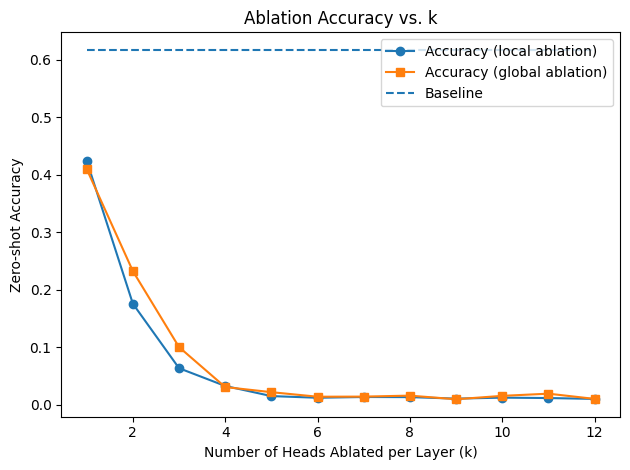

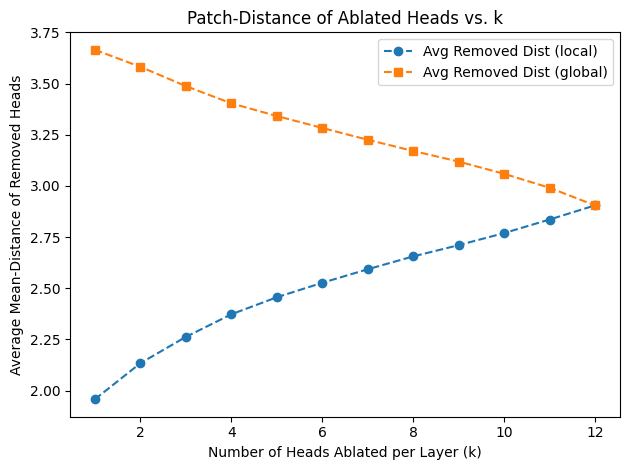

In [14]:
# 1) Accuracy plot
plt.figure()
plt.plot(ks, acc_local, marker='o', label='Accuracy (local ablation)')
plt.plot(ks, acc_global, marker='s', label='Accuracy (global ablation)')
plt.hlines(baseline_acc, ks[0], ks[-1], linestyles='dashed', label='Baseline')
plt.xlabel('Number of Heads Ablated per Layer (k)')
plt.ylabel('Zero‑shot Accuracy')
plt.title('Ablation Accuracy vs. k')
plt.legend()
plt.tight_layout()

# 2) Mean‑distance plot
plt.figure()
plt.plot(ks, dist_local, marker='o', linestyle='--', label='Avg Removed Dist (local)')
plt.plot(ks, dist_global, marker='s', linestyle='--', label='Avg Removed Dist (global)')
plt.xlabel('Number of Heads Ablated per Layer (k)')
plt.ylabel('Average Mean‑Distance of Removed Heads')
plt.title('Patch‑Distance of Ablated Heads vs. k')
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
# 10) Baseline accuracy
acc_base = eval_zero_shot()

# 11) Local-only ablation test  - try using more heads?
ablate(local_dict, keep=True)
acc_local = eval_zero_shot()
# restore
for layer, w0 in zip(model.vision_model.encoder.layers, orig_v):
    layer.self_attn.v_proj.weight.data.copy_(w0)

# 12) Global-ablated test
ablate(global_dict, keep=False)
acc_global = eval_zero_shot()
# restore
for layer, w0 in zip(model.vision_model.encoder.layers, orig_v):
    layer.self_attn.v_proj.weight.data.copy_(w0)

In [ ]:
for layer, w0 in zip(model.vision_model.encoder.layers, orig_v):
    layer.self_attn.v_proj.weight.data.copy_(w0)

In [ ]:
print(acc_base, acc_local, acc_global)

0.888 0.1222 0.6611


In [ ]:
# local-ablated test
ablate(local_dict, keep=False)
acc_local_abl = eval_zero_shot()
# restore
for layer, w0 in zip(model.vision_model.encoder.layers, orig_v):
    layer.self_attn.v_proj.weight.data.copy_(w0)
print(acc_local_abl)

0.7622


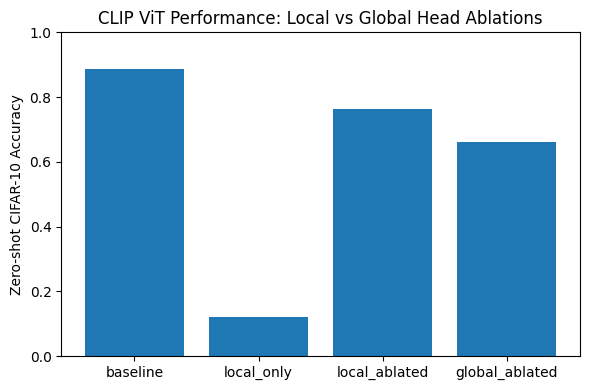

In [ ]:
# 13) Plot summary
conds = ["baseline", "local_only", "local_ablated", "global_ablated"]
accs = [acc_base, acc_local, acc_local_abl, acc_global]

plt.figure(figsize=(6,4))
plt.bar(conds, accs)
plt.ylabel("Zero-shot CIFAR-10 Accuracy")
plt.ylim(0,1)
plt.title("CLIP ViT Performance: Local vs Global Head Ablations")
plt.tight_layout()
plt.show()